<a href="https://colab.research.google.com/github/drc10723/GAN_design/blob/master/Neural_Style_Transfer/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

Our aim from this notebook is to implement Neural Style Transfer (https://arxiv.org/abs/1508.06576) and generate some cool T-Shirt designs.




Lets start by import

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import optim
from torchvision import models, transforms
from PIL import Image

import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

In [0]:
# Use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading images

We will need two images, a content image and a style image.

For uploading images, check upload_image checkbox and run cell, output cell will create upload widget.

Alternatively, you can give URL of images.

In [0]:
#@title Choose Content Image { display-mode: "form" }
# for uploading custom image from local, tick upload_image 
upload_image = False #@param {type:"boolean"}
# if upload is not ticked, will use image_url
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg/1024px-Green_Sea_Turtle_grazing_seagrass.jpg" #@param {type:"string"}
# content filename
content_file = "content.jpg"
# if upload, use collab API for upload
if upload_image:
  from google.colab import files
  _upload = files.upload()
  upload_file = list(_upload.keys())[0]
# use collab magic for renaming uploaded file
  !mv $upload_file $content_file
# download image from url, using colab magic
else:
  !wget -q -O $content_file $image_url
  

In [0]:
# load content image and show 
content_image = Image.open(content_file)
_ = plt.imshow(content_image)

In [0]:
#@title Choose Style Image { display-mode: "form" }
# for uploading custom image from local, tick upload_image 
upload_image = False #@param {type:"boolean"}
# if upload is not ticked, will use image_url
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg" #@param {type:"string"}
# style filename
style_file = "style.jpg"
# if upload, use collab API for upload
if upload_image:
  from google.colab import files
  _upload = files.upload()
  upload_file = list(_upload.keys())[0]
# use collab magic for renaming uploaded file  
  !mv $upload_file $style_file
# download image from url, using colab magic
else:
  !wget -q -O $style_file $image_url

In [0]:
# load style image and show 
style_image = Image.open(style_file)
_ = plt.imshow(style_image)

In [0]:
#@title Choose Target Image Size { display-mode: "form" }
print(f"content image size: {content_image.size}")
print(f"style image size: {style_image.size}")
# use original content image dimension
USE_ORIGINAL_SIZE = True #@param {type:"boolean"}
# maximum size allowed for image with height=width 
MAX_IMAGE_SIZE = 1000 #@param {type:"integer"}
# take original dimension
if USE_ORIGINAL_SIZE or max(content_image.size) < MAX_IMAGE_SIZE:
  out_size = (content_image.size[1], content_image.size[0])
else:
  # max size
  out_size = (MAX_IMAGE_SIZE, MAX_IMAGE_SIZE)
print(f"target image size: ({out_size[1]},{out_size[0]})")

content image size: (1024, 768)
style image size: (1280, 1014)
target image size: (1024,768)


In [0]:
# resize image, convert to tensor and normalize
# we will be using VGG19 pretrained model, so normalize with values used during training
image_transforms = transforms.Compose([transforms.Resize(out_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), 
                                                           (0.229, 0.224, 0.225))])
# apply transformations on content and style image and sent to GPU device
content = image_transforms(content_image).unsqueeze(0).to(DEVICE)
style = image_transforms(style_image).unsqueeze(0).to(DEVICE)

In [0]:
def tensor2image(tensor):
  """ Convert a tensor to an image. """
  # clone tensor and detach
  image = tensor.to("cpu").clone().detach()
  # squeeze batch dimension
  image = image.numpy().squeeze()
  # transpose image to (height, width, channel)
  image = image.transpose(1,2,0)
  # inverse normalization
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  # values between [0,1]
  image = image.clip(0, 1)
  return image

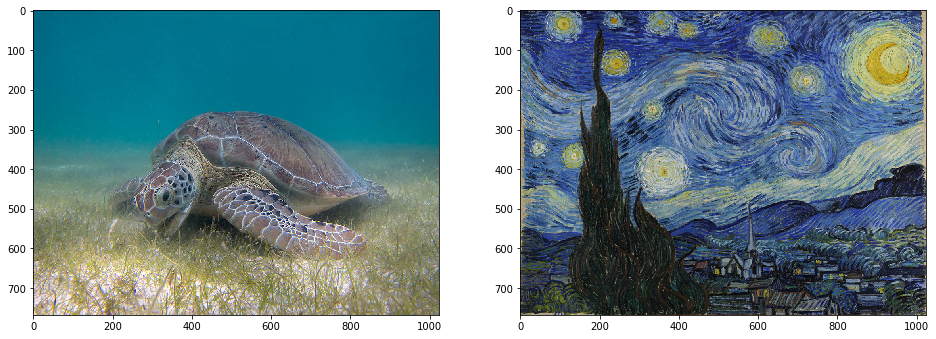

In [0]:
# display the content and style images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
# content and style images side-by-side
_ = ax1.imshow(tensor2image(content))
_ = ax2.imshow(tensor2image(style))

## Loading Model

We will use VGG19 pretrained model. Pretrained model will help us determine content and style of images.

![alt text](https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)

In [0]:
# load VGG19 model 
# remove classifier, only need features part
model = models.vgg19_bn(pretrained=True).features
# set gradient to false, we will not train model at all
# model is used only for extracting features
for param in model.parameters():
  param.requires_grad_(False)

In [0]:
# send model to GPU
model.to(DEVICE)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNor

In [0]:
def get_features(image, model, layers):
  """
    Given image, do forward pass and get feature output for given layers
  """
  # output feature dict
  features = {}
  x = image
  # model._modules is a dictionary holding each module in the model
  for name, layer in model._modules.items():
    # do forward pass on layer
    x = layer(x)
    # add to dict, if we need feature output
    if name in layers:
        features[layers[name]] = x  
  return features

## Content Cost

The content loss will be the mean squared difference between the target and content features. 

For content, we will use **conv4_2** layer from VGG19 model. 




In [0]:
# VGG19 layers, used for content loss
content_layers = {'21':'conv4_2'}

In [0]:
def compute_content_loss(content_features, target_features):
  """
    calculate content loss by MSE between content and target features
  """
  content_loss = 0
  # we can use mutiple layers also for content
  for layer, name in content_layers.items():
    # calculate MSE for layer
    content_loss += torch.mean((target_features[name] - content_features[name])**2)
  return content_loss

## Style Cost

Style cost will be distance between the Gram matrix of the style image and that of the  target image.

In [0]:
# layers used for style calculation
# using multiple layers and weighted avergaing
# more layers will create smooth and more pleasing target image
style_layers = {'0': 'conv1_1',
                '5': 'conv2_1', 
                '10': 'conv3_1', 
                '19': 'conv4_1',
                '28': 'conv5_1'}
# weights for style layers
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}


In [0]:
def gram_matrix(tensor):
  """ 
     Calculate the Gram Matrix of a given tensor 
  """

  # get the batch_size, depth, height, and width of the Tensor
  _, d, h, w = tensor.size()

  # reshape, multiplying the features for each channel
  tensor = tensor.view(d, h * w)

  # calculate the gram matrix
  gram = torch.mm(tensor, tensor.t())
    
  return gram

In [0]:
def compute_style_loss(style_grams, target_features):
  """
    calculate style loss for given target features
  """
  # initialize the style loss to 0
  style_loss = 0
  #add each layer's gram matrix loss
  for layer in style_weights:
    # get the target style representation for the layer
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape
    # get the style style representation
    style_gram = style_grams[layer]
    # the style loss for one layer
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    # add to the style loss
    style_loss += layer_style_loss /(d * h * w)
  return style_loss

## Content and Style Features

In [0]:
# get content and style features
content_features = get_features(content, model, content_layers)
style_features = get_features(style, model, style_layers)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a target image a
# Start with the target as a copy of our content image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(DEVICE)

## Training and Updating Target image

In [0]:
# weightage for content and style loss in total loss
# alpha
content_weight = 1
# beta
style_weight = 1e6
# layers for which target features are needed
target_layers = {**content_layers, **style_layers}

# save the target image after below steps
save_every = 400 #@param {type:"integer"}

# Adam optimizer
optimizer = optim.Adam([target], lr=0.003)
# number of iterations 
steps = 5000 #@param {type:"integer"}


In [0]:
# training steps 
for step in range(0, steps+1):
  #the features from target image
  target_features = get_features(target, model, target_layers)

  # the content loss
  content_loss = compute_content_loss(content_features, target_features)

  # the style loss
  style_loss = compute_style_loss(style_grams, target_features)

  # calculate total loss
  total_loss = content_weight * content_loss + style_weight * style_loss

  # update target image
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  # save intermediate images and print the loss
  if  step % save_every == 0:
    print(f"Steps {step} Content loss: {content_loss.item():.3f}",
          f"Style loss: {style_loss.item():.3f} Total loss: {total_loss.item():.3f}")
    im = Image.fromarray((255*tensor2image(target)).astype(np.uint8))
    im.save(f"target_{step}.jpg")

## Display Target Image

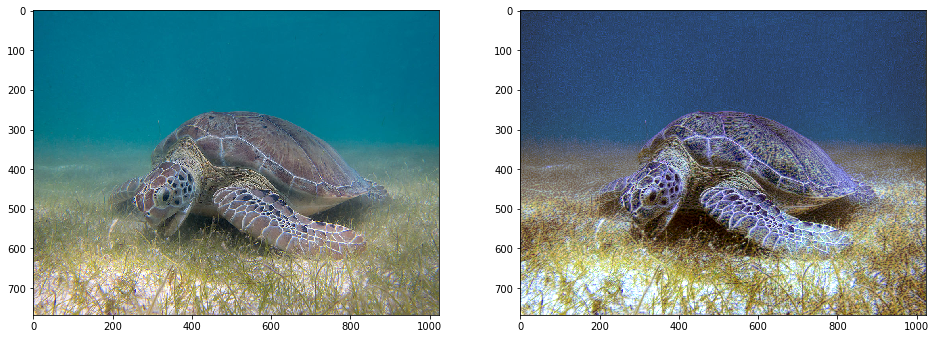

In [0]:
# display content and final target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
_ = ax1.imshow(tensor2image(content))
_ = ax2.imshow(tensor2image(target))

In [0]:
%%capture
# using capture magic for avoiding extra outputs
fig = plt.figure(figsize=(16,8))
plt.axis("off")
# load all images
ims = [[plt.imshow(Image.open(f"target_{i}.jpg"), animated=True)] for i in range(0, steps+1) if i%save_every == 0]
# create animation 
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

In [0]:
# showing animation using Ipython HTML
HTML(ani.to_jshtml())

In [0]:
ani.save('neural_style_transfer_animation.gif', writer='imagemagick', fps=5)